This notebook is written by Mathias Rose Bjare (s113038@student.dtu.dk) and  answears Deep RL Assignment 1, http://rail.eecs.berkeley.edu/deeprlcourse/static/homeworks/hw1.pdf.
The code base for this file can be found at https://github.com/muthissar/homework.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from behavioral_cloning import *
from load_policy import load_policy
import matplotlib.pyplot as plt

# DAGGER
Implimentation of the dagger algorithm. The algoirthm is run on the 'Hopper-v2' task, for which behaviroal cloning failed to perform as well as expert. The setup is as identical to the setup for previous section. The network is identical, the algorithm is initialized with the same number of expert rollouts (20). About 10 iterations is needed to perform as good as the expert. At each iteration 20 rollouts are made, and the return is computed and stored. This is printed in the table below.

In [23]:
batch_size = 32
expert_rollout = 20
dagger_rollout = 20
#0 = run until termination
max_timesteps = 0
use_expert_cache = True
store=False
training_epochs = 1
losses = []

from IPython.display import display, clear_output
import matplotlib.pyplot as plt

tf.reset_default_graph()
losses = []

it_dagger = 10
#tasks = ['Hopper-v2', 'Ant-v2', 'HalfCheetah-v2',
# 'Humanoid-v2', 'Reacher-v2','Walker2d-v2']
tasks = ['Hopper-v2']
results = pd.DataFrame(columns=[])
for task in tasks:
    tf.reset_default_graph()
    with tf.Session() as sess:
        expert_policy = load_policy('./experts/{}.pkl'.format(task))
        if use_expert_cache:
            dataset, expert_returns = get_dataset(\
                './expert_data/{}-{}.pkl'.format(task,expert_rollout))
        else:
            dataset, expert_returns = get_dataset(\
                envname=task,render=False,
                expert_policy_file='experts/'+task+'.pkl'\
                ,max_timesteps=0,num_rollouts=expert_rollout,store=store)
        dataset = dataset.map(lambda x, y: (tf.cast(x,tf.float32),y))
        obs_dim = dataset.output_shapes[0].as_list()
        action_dim = dataset.output_shapes[1].as_list()[1:]
        dataset = dataset.repeat(training_epochs)
        batched_dataset = dataset.batch(batch_size)
        iterator = batched_dataset.make_one_shot_iterator()
        next_element = iterator.get_next()
        # FNN network
        behavioral_net = BehavioralCloningNet(obs_dim, action_dim,\
            batch_size,learning_rate=0.01)
        losses = []
        returns = []
        # object used for interacting with gym environment
        evaluate = EvaluateDagger(task,expert_policy,behavioral_net,render=False)
        for i in range(it_dagger):
            losses += behavioral_net.train(next_element)
            evaluate.expert_obs = []
            evaluate.expert_actions = []
            return_ = evaluate.evaluate(rollouts=dagger_rollout)
            print("dagger it {}, mean return {}".format(i,np.mean(return_)))
            returns.append(return_)
            expert_obs_arr = np.asarray(evaluate.expert_obs,dtype=np.float32)
            expert_actions_arr = np.asarray(evaluate.expert_actions,\
                dtype=np.float32)
            expert_labeled_new_data = tf.data.Dataset.from_tensor_slices(\
                (expert_obs_arr,expert_actions_arr))
            dataset = dataset.concatenate(expert_labeled_new_data)
            dataset = dataset.shuffle(buffer_size=10000)
            # avoid that the dataset explodes eponentially by having
            #a cutoff for which the dataset will then grow linearly.
            dataset = dataset.take(1000000)
            batched_dataset = dataset.batch(batch_size,True)
            iterator = batched_dataset.make_one_shot_iterator()
            next_element = iterator.get_next()
            results = results.append({'Task': task,
                                'mean return': np.mean(return_),
                                'std return': np.std(return_),
                                'expert mean return': np.mean(expert_returns),
                                'expert std return': np.std(expert_returns),
                                'expert rollouts': expert_rollout,
                                'training epochs': training_epochs,
                                'dagger its': i},
                                ignore_index=True)
#fig = plt.figure()
#plt.plot(losses)
#plt.xlabel('Batch')
#plt.ylabel('Loss (mean square)')
#plt.legend(['Train loss {}'.format(task)],loc='upper center')
#plt.show(fig)
results.to_csv('results_dagger.csv')

obs (1, 11) (1, 11)
dagger it 0, mean return 736.0769779547579
dagger it 1, mean return 830.7500919300234
dagger it 2, mean return 874.0364912999794
dagger it 3, mean return 3580.920743705319
dagger it 4, mean return 1317.9380580686814
dagger it 5, mean return 1334.4896558361386
dagger it 6, mean return 3101.087675328911
dagger it 7, mean return 3497.9828368728427
dagger it 8, mean return 3771.0546427939344
dagger it 9, mean return 3621.78699838433


Possibly run from cached results

In [2]:
results = pd.read_csv('results_dagger.csv')

## Learning curve
Learning curve is plotted for different dagger iterations. Also the experts return is plotted. It is seen at some steps that the variance of the 20 rollouts are high, and that the convergence to the experts return is jumpy.

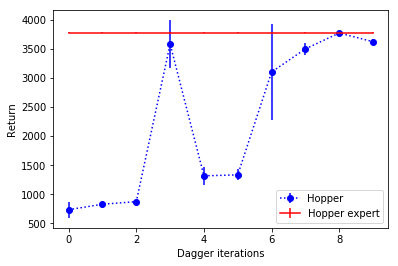

In [3]:
fig = plt.figure()
hopper_data = results[results['Task']=='Hopper-v2']
dagger_its = hopper_data['dagger its'].values
plt.errorbar(dagger_its,hopper_data['mean return'].values,\
    yerr=[hopper_data['std return'], hopper_data['std return'],], c='blue',fmt='-o',linestyle=":")
plt.errorbar(dagger_its,hopper_data['expert mean return'].values,\
    yerr=[hopper_data['expert std return'], hopper_data['expert std return']\
    ,], c='red')
plt.xlabel("Dagger iterations")
plt.ylabel("Return")
plt.legend(['Hopper','Hopper expert'])
plt.show(fig)

%%latex
\lstinputlisting[language=Python]{behavioral_cloning.py}